In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from hazm import word_tokenize, stopwords_list, InformalLemmatizer
import re
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud
import warnings
import os
warnings.filterwarnings(action='ignore')
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
%matplotlib inline

# Loading Data

In [ ]:
df = pd.read_csv('/train.csv')

In [ ]:
df.head()

# lets get rid of null values

In [ ]:
df = df[~((df.title.isnull()) & (df.comment.isnull()))]
df = df.reset_index(drop=True)

# Managing data types

In [ ]:
df.dtypes

In [ ]:
def set_types(df):
    df.title = df.title.astype(str)
    df.comment = df.comment.astype(str)
    df.rate = df.rate.astype('int')
    return df
df = set_types(df)

# Managing NaNs

In [ ]:
def replace_nan(entry):
    if entry == 'nan':
        return '#'
    return entry
df.title = df.title.apply(replace_nan)
df.comment = df.comment.apply(replace_nan)

# Concating title and text


In [ ]:
df['text'] = df['title'] + ' ' + df['comment']
# swap text and target values
# And also exclude id colmn => No longer is needed
df = df.reindex(columns=['title', 'comment', 'text', 'rate', 'verification_status'])
df.head(1)

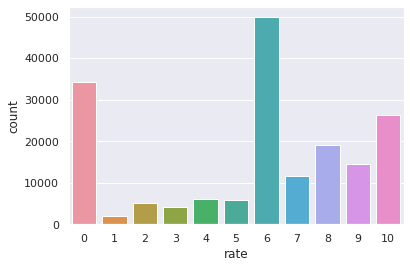

In [ ]:
df.rate = df.rate.apply(lambda x: int(x// 10))
df.rate = df.rate.astype('category')
sns.countplot(df.rate)

# Cleaning time

In [ ]:
lemma = InformalLemmatizer()

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py  emoticons list
# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt Chat shortcuts

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r' ', text)

def remove_punctuations(text):
    punctuations = re.compile(r'[~`!@#$%^&*(,<،>){}\\/|\'"?؟_+-=~\[\]]')
    return punctuations.sub(r' ', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r' ', text)

def remove_weird_chars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    patterns = [re.compile('\r'), re.compile('\n'), re.compile('&amp;')]
    text = weridPatterns.sub(r'', text)
    for p in patterns:
        text = p.sub(r' ', text)
    return text

def remove_extra_repeated_alpha(text):
    """
    Remove extra repeated alphabets in a word
    check these links:
    demo : https://regex101.com/r/ALxocA/1
    Question: https://bit.ly/2DoiPqS
    """
    return re.sub(r'([^\W\d_])\1{2,}', r'\1', text)


def clean_up(text, url=True, html=True, weird_patterns=True , lemmatize=False, 
               stopwords=True, isalpha=False, punctuations=True, remove_extra_alpha=True):
    # remove url
    if url:
        text = remove_urls(text)
    # remove html tags
    if html:
        text = remove_html(text)
    # remove emokis / symbols & pictographs / transport & map symbols / flags (iOS)
    if weird_patterns:
        text = remove_weird_chars(text)
    # remove punctuations
    if punctuations:
        text = remove_punctuations(text)
    # Alter words with repeated alphabets
    if remove_extra_repeated_alpha:
        text = remove_extra_repeated_alpha(text)
    # tokenize text
    tokens = word_tokenize(text)
    # remove stop words
    if stopwords:
        tokens = [word for word in tokens if word not in stopwords_list()]
    # remove non-alphabetic items
    if isalpha:
        tokens = [word for word in tokens if word.isalpha()]
    # lemmatize words
    if lemmatize:
        tokens = [lemma.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    
    return text

# df[df.comment.str.len()>4000].head(10)
# a = df.iloc[60659].comment
# a
# preprocess(str(a))


# Appending the functions to our data frame

In [ ]:
for index, row in progressbar(df.iterrows(), total=df.shape[0]):
    row = row.copy()
    comment = remove_punctuations(row.comment)
    title = remove_punctuations(row.title)
    text = remove_punctuations(row.text)
    df.loc[index, 'title'] = title
    df.loc[index, 'comment'] = comment
    df.loc[index, 'text'] = text

# Save preprocessed data
df.to_csv('/data.csv', index=False)

100%|██████████| 179099/179099 [1:18:54<00:00, 37.83it/s]


# Perprocessing Sentences in comments

In [ ]:
def set_types(df):
    df.title = df.title.apply(str)
    df.comment = df.comment.apply(str)
    df.text = df.text.apply(str)
    return df

df = set_types(df)

In [ ]:
# Storing comments in list
comments = [comment for comment in df.comment]

In [ ]:
# convertingeach sentence to list of words and inserting in sents
sents = [word_tokenize(comment) for comment in comments]
sents[45]

# doing the word2vec for the comments

In [ ]:
model = Word2Vec(sentences=sents, size=64, window=10, min_count=5, seed=42, workers=5)

In [ ]:
model.save('digikala_words.w2v')